In [1]:
# Mounting Google Drive so you can access the file system
from google.colab import drive #You're importing the drive module
drive.mount('/content/drive', force_remount=True) #You're using the function "mount." The argument is the path to the drive

Mounted at /content/drive


In [2]:
# Adding Colab Notebooks folder to the search path so you can access...
# ...your own module
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [3]:
# Imports and installs
# Importing pandas
import pandas as pd

# Installing and importing fiona
!pip install fiona
import fiona

# Installing and importing geopandas
!pip install geopandas
import geopandas

import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [4]:
import geopandas as gpd
shapefile = '/content/drive/MyDrive/Colab Notebooks/Lab6/gpr_000b11a_e.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['PRUID', 'PRNAME', 'geometry']]
#Rename columns.
gdf.columns = ['pruid', 'prname', 'geometry']


In [5]:
#gdf

In [6]:
###PERCENTAGE%%%
import pandas as pd
datafile = 'https://health-infobase.canada.ca/src/data/covidLive/vaccination-coverage-map.csv'
#Read csv file using pandas
df = pd.read_csv(datafile, names = ['week_end','pruid','prname','prfname','numtotal_atleast1dose','numtotal_1dose','numtotal_2doses','proptotal_atleast1dose','proptotal_1dose','proptotal_2doses'], skiprows=1)
df.pop('prfname')
df.pop('numtotal_1dose')
df.pop('numtotal_2doses')
df.pop('proptotal_1dose')
df.pop('proptotal_2doses')
df = df[~df.prname.str.contains("Canada")] # Removes Canada rows
df['pruid'] = df['pruid'].apply(str) #pruid object to str
df['week_end'] = pd.to_datetime(df.week_end) #converts string_date to pd_date
list3 = df.week_end.dt.week
df['week'] = list3   #df['as_of_date'] = df.report_date.dt.week


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [7]:
df.head(20)

,week_end,pruid,prname,numtotal_atleast1dose,proptotal_atleast1dose,week
1,2020-12-19,10,Newfoundland and Labrador,972,0.186170,51
2,2020-12-19,12,Nova Scotia,1092,0.111502,51
3,2020-12-19,24,Quebec,4728,0.055140,51
4,2020-12-19,46,Manitoba,894,0.064817,51
5,2020-12-19,47,Saskatchewan,1048,0.088913,51
6,2020-12-19,61,Northwest Territories,0,0.000000,51
7,2020-12-19,60,Yukon,0,0.000000,51
8,2020-12-19,62,Nunavut,0,0.000000,51
10,2020-12-26,10,Newfoundland and Labrador,1785,0.341887,52
11,2020-12-26,11,Prince Edward Island,1152,0.721691,52


In [8]:
df = df[df.week != 51]
df = df[df.week != 52]
df = df[df.week != 53]
df = df[df.week != 1]
df = df[df.week != 2]

In [9]:
###If i did this again i would avoid this step, unnecessary to import dataframe, but was working in R logic
datafile = '/content/drive/MyDrive/Colab Notebooks/pruidweek.csv'
#Read csv file using pandas
df8 = pd.read_csv(datafile) #skiprows=0
df8['pruid'] = df8['pruid'].apply(str)
df8.head()
df8.fillna(0)
#thought that this merge would suffice in my shapefile requirements later, but was wrong.
gdf2  = df8.merge(gdf, on='pruid', how='right')
df.rename(columns={'proptotal_atleast1dose':'pt'}, inplace=True)

In [10]:
gdf2.head(20)

,pruid,week3,week4,week5,week6,week7,week8,week9,week10,week11,week12,week13,week14,week15,week16,week17,week18,week19,week20,week21,week22,week23,week24,week25,week26,week27,week28,week29,week30,week31,week32,week33,week34,week35,week36,week37,week38,week39,week40,week41,week42,week43,week44,week45,week46,week47,week48,week49,week50,week51,week52,prname,geometry
0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,British Columbia / Colombie-Britannique,"MULTIPOLYGON (((-123.53977 48.31735, -123.5397..."
1,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quebec / Québec,"MULTIPOLYGON (((-74.63814 44.99984, -74.63859 ..."
2,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nunavut,"MULTIPOLYGON (((-79.99352 51.27725, -79.99475 ..."
3,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Prince Edward Island / Île-du-Prince-Édouard,"MULTIPOLYGON (((-62.49302 46.02515, -62.49337 ..."
4,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saskatchewan,"POLYGON ((-102.00000 60.00000, -102.00000 59.9..."
5,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yukon,"MULTIPOLYGON (((-136.47224 68.89388, -136.4705..."
6,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manitoba,"MULTIPOLYGON (((-95.15588 49.59155, -95.15657 ..."
7,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ontario,"MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ..."
8,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,New Brunswick / Nouveau-Brunswick,"MULTIPOLYGON (((-66.76541 44.58377, -66.76462 ..."
9,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Northwest Territories / Territoires du Nord-Ouest,"MULTIPOLYGON (((-133.43943 68.78677, -133.4430..."


In [11]:
#Inputs csv data into gdf2 by 'week{x}'
###index, row builds index to read df
for index, row in df.iterrows():
  pt = row['pt']
  w = row['week']
  id = row['pruid']
  wk = 'week{}'.format(w)
  gdf2.loc[gdf2.pruid == id, wk] = pt
gdf2 = gdf2.replace(np.nan, 0)  ###Replace NaN in Saskatchewan
###code before to remember
  #wk = 'week5'
  #gdf2.loc[gdf2.pruid == 10, wk]

In [12]:
###Simple Model for Regression
def simple_model(i, j):
  xarray = np.array(i).reshape((-1, 1))
  yarray = np.array(j)
  model = LinearRegression().fit(xarray, yarray)
  return model

In [13]:
###Logistic Model for Regression
def log(x, y):
  x = x.astype(int)
  y = y.astype(int)
  logmodel = LogisticRegression(max_iter=400).fit(x, y)
  return logmodel

In [14]:
###Test Linear, Exponential, or logistic best fit
def r_test(i, j):
  xarray = np.array(i).reshape((-1, 1))
  yarray = np.array(j)
  model = LinearRegression().fit(xarray, yarray)
     ######Various tests, logarithmic becomes better in one case, function
  r_sq = model.score(xarray, yarray) #linear r_sq for testing
  x2 = np.log(xarray)
  y2 = np.log(yarray)
  modellog = LinearRegression().fit(x2, yarray)
  r_sqlog = modellog.score(x2,yarray)
  if r_sqlog > r_sq:
    model = modellog #if log a better fit employ modellog
  modelpow = LinearRegression().fit(x2, y2)
  r_sqpow =  modelpow.score(x2,y2)
  if r_sqpow > r_sq:
    model = modelpow #if pow curve a better fit employ modelpow
  return model

In [15]:
####Prediction DF
var = 0
for index, row in gdf2.iterrows():
  val_list = []
  indexed = []
  var = var + 1 #Keeping place in row order(must be a better way but i don't know it)
  count = 0
  for x in row[1:]:
   if x != 0:
     count = count + 1
     val_list.append(x)
     indexed.append(count)
   elif x == 0:
     count = count + 1
     model = simple_model(indexed, val_list)
     
     #model = r_test(indexed, val_list) #Bug - Calculates but doesn't extrapolate properly
     #Everything but Yukon still best fit linearly.
     
     predict = model.intercept_ + model.coef_*(count + 2)
     wk = 'week{}'.format(count + 2)
     if predict > 100:
       predict = 100 
     gdf2.loc[var - 1, wk] = predict

In [16]:
#I removed the first two weeks due to incomplete data so unfortunately week11 of my study corresponds to week13 real world.
gdf2.head(20)

,pruid,week3,week4,week5,week6,week7,week8,week9,week10,week11,week12,week13,week14,week15,week16,week17,week18,week19,week20,week21,week22,week23,week24,week25,week26,week27,week28,week29,week30,week31,week32,week33,week34,week35,week36,week37,week38,week39,week40,week41,week42,week43,week44,week45,week46,week47,week48,week49,week50,week51,week52,prname,geometry
0,59,2.227630,2.566499,2.759945,2.883572,3.178364,3.726316,6.473847,7.945918,10.459618,11.380589,12.336202,13.291814,14.247427,15.203039,16.158652,17.114265,18.069877,19.025490,19.981102,20.936715,21.892327,22.847940,23.803553,24.759165,25.714778,26.670390,27.626003,28.581615,29.537228,30.492841,31.448453,32.404066,33.359678,34.315291,35.270904,36.226516,37.182129,38.137741,39.093354,40.048966,41.004579,41.960192,42.915804,43.871417,44.827029,45.782642,46.738254,47.693867,48.649480,49.605092,British Columbia / Colombie-Britannique,(POLYGON ((-123.5397725159999 48.3173484960000...
1,24,2.552116,2.793143,3.003147,3.425757,4.035071,5.035237,6.391468,8.327402,11.025461,12.046133,13.027504,14.008876,14.990247,15.971619,16.952990,17.934361,18.915733,19.897104,20.878475,21.859847,22.841218,23.822589,24.803961,25.785332,26.766703,27.748075,28.729446,29.710817,30.692189,31.673560,32.654932,33.636303,34.617674,35.599046,36.580417,37.561788,38.543160,39.524531,40.505902,41.487274,42.468645,43.450016,44.431388,45.412759,46.394130,47.375502,48.356873,49.338245,50.319616,51.300987,Quebec / Québec,(POLYGON ((-74.63814234299991 44.9998372320000...
2,62,11.302823,13.884583,14.865449,16.512083,17.729271,18.809239,23.375600,26.112368,30.132391,34.512094,36.700746,38.889397,41.078049,43.266700,45.455351,47.644003,49.832654,52.021306,54.209957,56.398609,58.587260,60.775911,62.964563,65.153214,67.341866,69.530517,71.719169,73.907820,76.096472,78.285123,80.473774,82.662426,84.851077,87.039729,89.228380,91.417032,93.605683,95.794335,97.982986,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,Nunavut,(POLYGON ((-79.99351691899994 51.2772504150000...
3,11,3.269538,3.309005,3.326547,3.576507,4.050744,4.620830,5.432107,6.510885,8.148473,8.704478,9.277425,9.850372,10.423319,10.996266,11.569213,12.142160,12.715107,13.288054,13.861001,14.433948,15.006895,15.579842,16.152789,16.725736,17.298683,17.871630,18.444577,19.017524,19.590471,20.163418,20.736365,21.309312,21.882259,22.455206,23.028153,23.601100,24.174047,24.746994,25.319941,25.892888,26.465835,27.038782,27.611729,28.184676,28.757623,29.330570,29.903517,30.476464,31.049411,31.622358,Prince Edward Island / Île-du-Prince-Édouard,(POLYGON ((-62.49301775499993 46.0251520690000...
4,47,2.008856,2.310294,2.526298,2.790238,3.205702,3.928120,4.794597,5.909572,8.579760,8.994129,9.706728,10.419327,11.131925,11.844524,12.557123,13.269722,13.982321,14.694919,15.407518,16.120117,16.832716,17.545315,18.257913,18.970512,19.683111,20.395710,21.108309,21.820907,22.533506,23.246105,23.958704,24.671303,25.383901,26.096500,26.809099,27.521698,28.234297,28.946895,29.659494,30.372093,31.084692,31.797291,32.509889,33.222488,33.935087,34.647686,35.360285,36.072883,36.785482,37.498081,Saskatchewan,POLYGON ((-102.0000000129999 59.99999999800008...
5,60,9.395510,17.497384,24.843051,25.026158,25.237801,26.060592,34.635689,45.612575,52.663369,61.434520,66.068465,70.702411,75.336356,79.970301,84.604247,89.238192,93.872137,98.506082,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,Yukon,(POLYGON ((-136.4722395469999 68.8938845840000...
6,46,1.873392,2.352053,2.439056,2.526567,2.630318,3.382314,4.306648,5.240625,6.567130,7.216809,7.750669,8.284529,8.818389,9.352249,9.886109,10.419969,10.953829,11.487689,12.

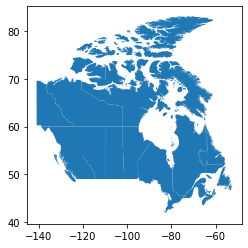

In [17]:
gdf.plot()

In [ ]:
map_df = gdf2[['pruid','week5', 'week13', 'week20', 'week30', 'week40', 'week52']]
map_df['week5'] = gdf2[('week3')].astype(float)
map_df['week13'] = gdf2[('week11')].astype(float)
map_df['week20'] = gdf2[('week18')].astype(float)
map_df['week30'] = gdf2[('week28')].astype(float)
map_df['week40'] = gdf2[('week38')].astype(float)
map_df['week52'] = gdf2[('week50')].astype(float)
map_df['pruid'] = map_df[('pruid')].astype(int)
gdf['pruid'] = gdf[('pruid')].astype(int)

In [19]:
map_df['MedSpend'] =  [1, 2, 13, 5, 7, 11, 6, 3, 4, 12, 9, 10, 8] #[13, 12, 1, 9, 7, 3, 8, 11, 10, 2, 5, 4, 6] Reversed Ranking
map_df['Rank'] =   [9, 10, 11, 5, 7, 13, 3, 6, 2, 12, 6, 4, 1] #[5, 4, 3, 9, 7, 1, 11, 8, 12, 2, 6, 10, 13] Reversed Ranking

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#map_df.head(13)

In [21]:
#map_df.dtypes

In [22]:
merged = gdf.set_index('pruid').join(map_df.set_index('pruid'))

In [23]:
#merged.head(20)

In [24]:
import matplotlib.pyplot as plt

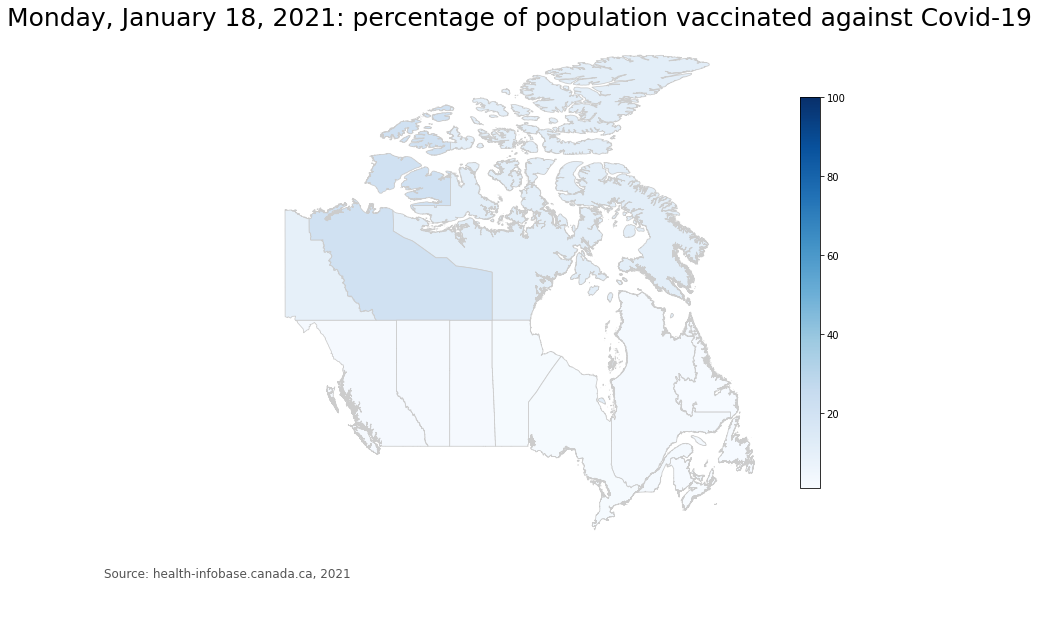

In [25]:
# set a variable that will call whatever column we want to visualise on the map
variable05 = 'week5'
vmin, vmax = 1, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=variable05, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 100)
ax.axis('off')

# add a title
ax.set_title('Monday, January 18, 2021: percentage of population vaccinated against Covid-19', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
plt.colorbar(sm, fraction=0.035, pad=0.04)

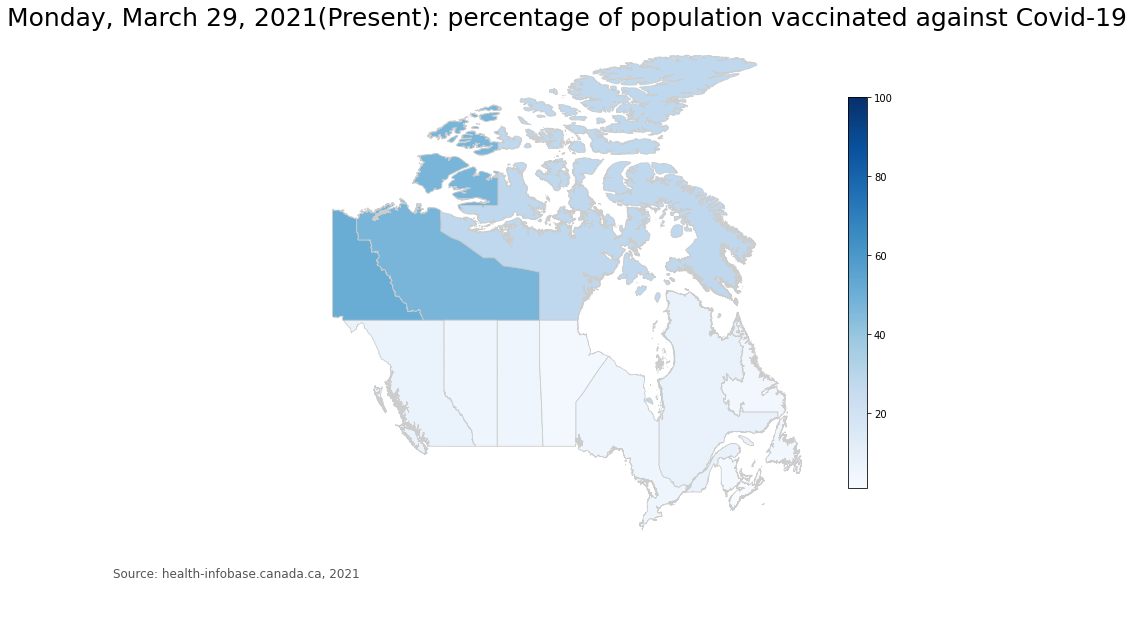

In [26]:
# set a variable that will call whatever column we want to visualise on the map
variable13 = 'week13'
vmin, vmax = 1, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=variable13, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 100)
ax.axis('off')

# add a title
ax.set_title('Monday, March 29, 2021(Present): percentage of population vaccinated against Covid-19', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
#cbar = fig.colorbar(sm)
# Better Colorbar
plt.colorbar(sm, fraction=0.035, pad=0.04)

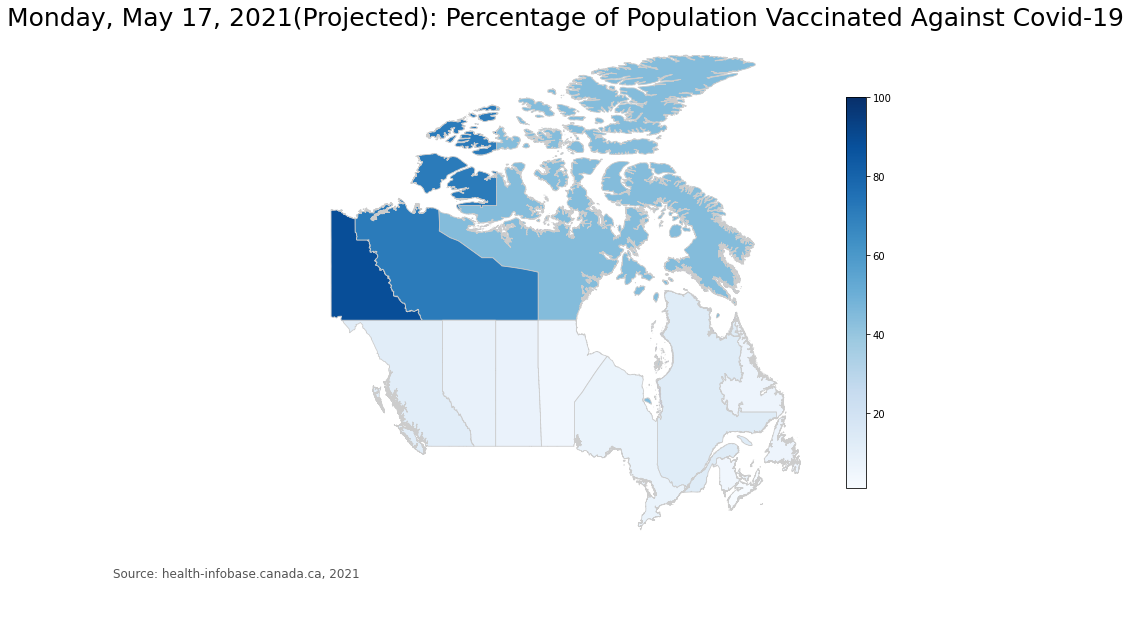

In [27]:
# set a variable that will call whatever column we want to visualise on the map
variable20 = 'week20'
vmin, vmax = 1, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=variable20, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 100)
ax.axis('off')

# add a title
ax.set_title('Monday, May 17, 2021(Projected): Percentage of Population Vaccinated Against Covid-19', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

#sm = plt.cm.get_cmap(name='Blues', lut=128)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
plt.colorbar(sm, fraction=0.035, pad=0.04)

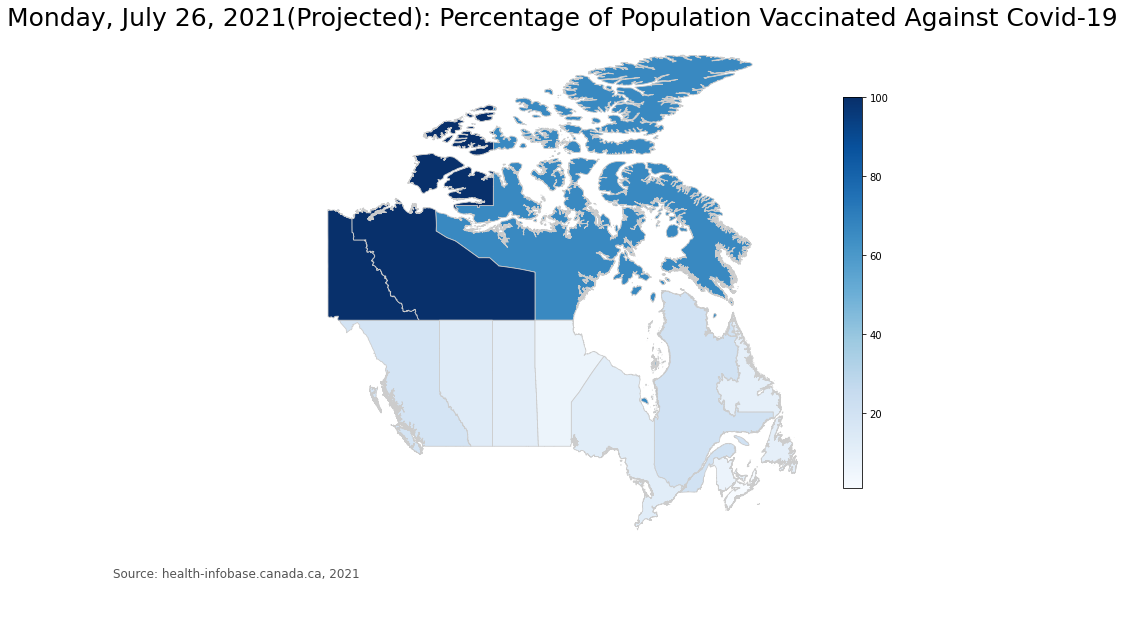

In [28]:
# set a variable that will call whatever column we want to visualise on the map
variable30 = 'week30'
vmin, vmax = 1, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=variable30, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 100)
ax.axis('off')

# add a title
ax.set_title('Monday, July 26, 2021(Projected): Percentage of Population Vaccinated Against Covid-19', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

#sm = plt.cm.get_cmap(name='Blues', lut=128)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
plt.colorbar(sm, fraction=0.035, pad=0.04)

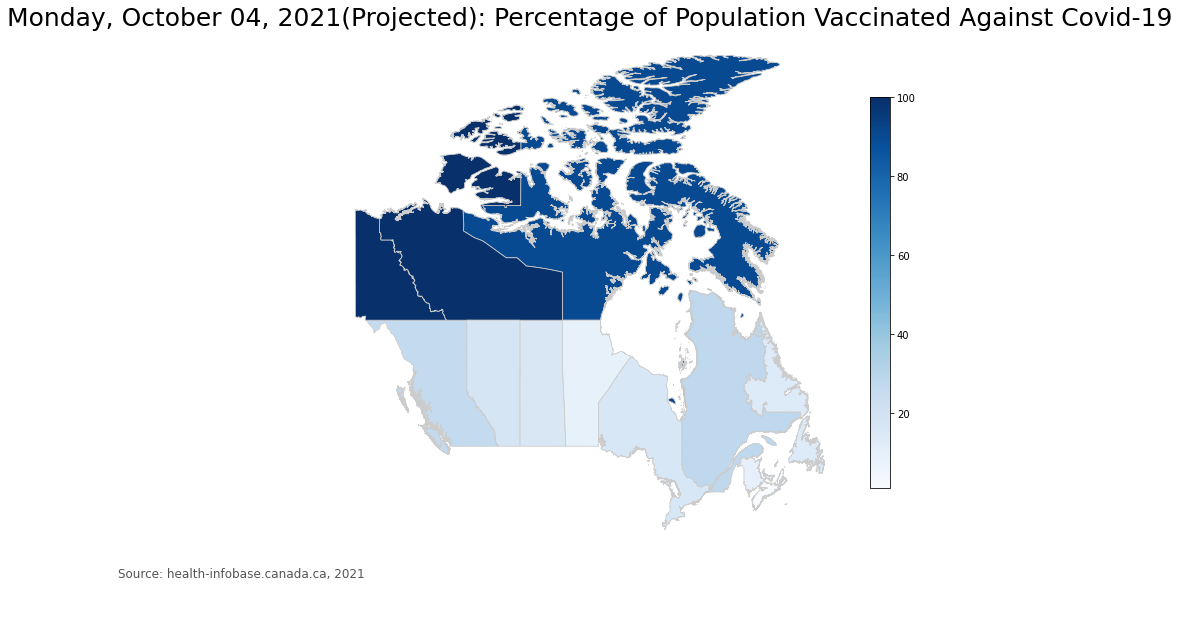

In [29]:
# set a variable that will call whatever column we want to visualise on the map
variable40 = 'week40'
vmin, vmax = 1, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=variable40, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 100)
ax.axis('off')

# add a title
ax.set_title('Monday, October 04, 2021(Projected): Percentage of Population Vaccinated Against Covid-19', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

#sm = plt.cm.get_cmap(name='Blues', lut=128)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
plt.colorbar(sm, fraction=0.035, pad=0.04)

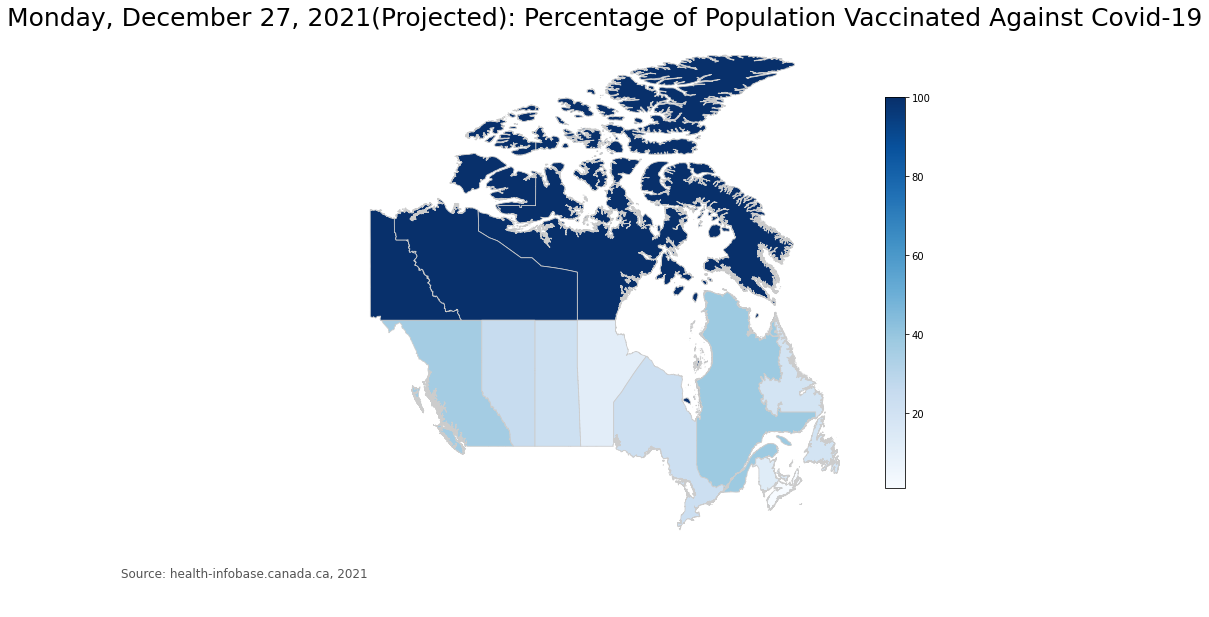

In [30]:
# set a variable that will call whatever column we want to visualise on the map
variable52 = 'week52'
vmin, vmax = 1, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=variable52, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 100)
ax.axis('off')

# add a title
ax.set_title('Monday, December 27, 2021(Projected): Percentage of Population Vaccinated Against Covid-19', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

#sm = plt.cm.get_cmap(name='Blues', lut=128)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
plt.colorbar(sm, fraction=0.035, pad=0.04)

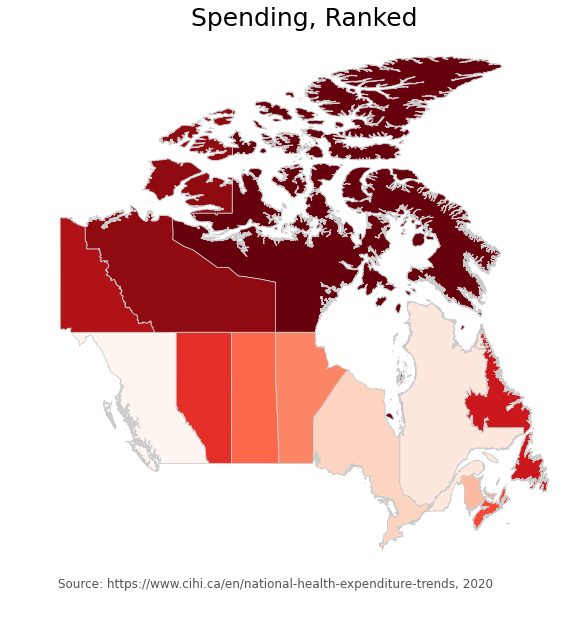

In [31]:
#MedSpending
MedSpend = 'MedSpend'
vmin, vmax = 1, 13

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=MedSpend, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 13)
ax.axis('off')

# add a title
ax.set_title('Spending, Ranked', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: https://www.cihi.ca/en/national-health-expenditure-trends, 2020',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
#plt.colorbar(sm, fraction=0.035, pad=0.04)

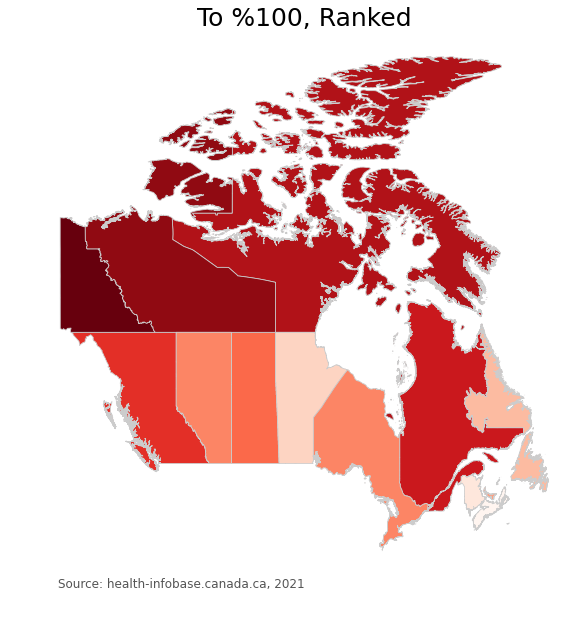

In [32]:
#Rank
Rank = 'Rank'
vmin, vmax = 1, 13

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
merged.plot(column=Rank, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', vmax = 13)
ax.axis('off')

# add a title
ax.set_title('To %100, Ranked', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: health-infobase.canada.ca, 2021',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
#plt.colorbar(sm, fraction=0.046, pad=0.04)

In [33]:
#Math Testing 


x = np.array([3, 4, 5, 6, 7, 8, 9, 10]).reshape((-1, 1))
y = np.array([11.30, 13.89, 14.87, 16.51, 17.72, 18.81, 23.38, 26.11])
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
#model = LogisticRegression()
#model = LogisticRegression(x,y)
#y_pred = model.predict(x2)
x2 = np.log(x)
y2 = np.log(y)
modellog = LinearRegression().fit(x2, y)
r_sqlog = modellog.score(x2,y)
modelpow = LinearRegression().fit(x2, y2)
r_sqpow =  modelpow.score(x2,y2)
data = {'lin' : r_sq, 'log': r_sqlog, 'pow': r_sqpow}
print (max(data, key=data.get))
###Here's where you can try a log model(curve fit exponential) if r-sq is low

print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')
print(model.intercept_ + model.coef_*11) ####GOOD PREDICTION

lin
coefficient of determination: 0.9490338613929686
intercept: 5.121666666666663
slope: [1.95416667]
predicted response:
[10.98416667 12.93833333 14.8925     16.84666667 18.80083333 20.755
 22.70916667 24.66333333]
[26.6175]


In [34]:
#Logistic Regression model I couldn't get working, but there's another passable one up top!
def log(x, y):
  x = x.astype(int)
  y = y.astype(int)
  logmodel = LogisticRegression(max_iter=400).fit(x, y)
  print(logmodel)
  print(logmodel.score(x, y))
  print(logmodel.intercept_ + logmodel.coef_ * 20)
  model = logmodel
  return model

In [35]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]).reshape((-1, 1))
y = np.array([11, 12, 14, 17, 21, 26, 32, 39, 45, 50, 54, 57])
r_test(x, y) 
#model = LinearRegression().fit(x, y)
predict = model.intercept_ + model.coef_*(16)
print(model)
print(predict)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[36.38833333]
